In [1]:
import pennylane.numpy as np
import matplotlib.pyplot as plt
from qml_essentials.model import Model
from qml_essentials.coefficients import Coefficients

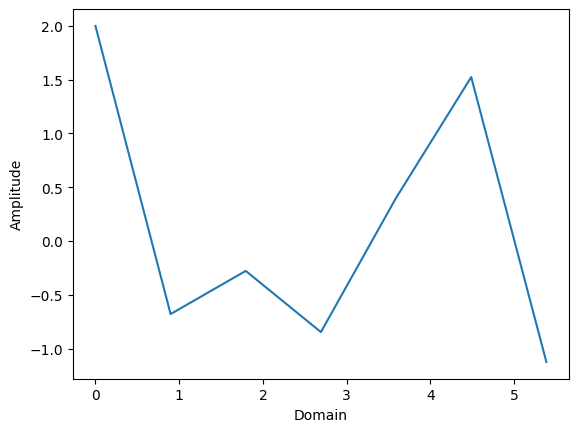

In [2]:
class Model_Fct:
    def __init__(self, c, f):
        self.c = c
        self.f = f
        self.degree = max(f)
        self.n_input_feat = 1

    def __call__(self, inputs, **kwargs):
        return np.sum([c * np.cos(inputs * f) for f, c in zip(self.f, self.c)], axis=0)

freqs = [1.5,3]
coeffs = [1,1]

fs = max(freqs) * 2 + 1
model_fct = Model_Fct(coeffs,freqs)

x = np.arange(0,2 * np.pi, 2 * np.pi/fs)
out = model_fct(x)

fig, ax = plt.subplots()
ax.plot(x, out)
plt.xlabel('Domain')
plt.ylabel('Amplitude')
plt.savefig("figures/model_fct_light.png", dpi=100, transparent=True)
plt.show()

7


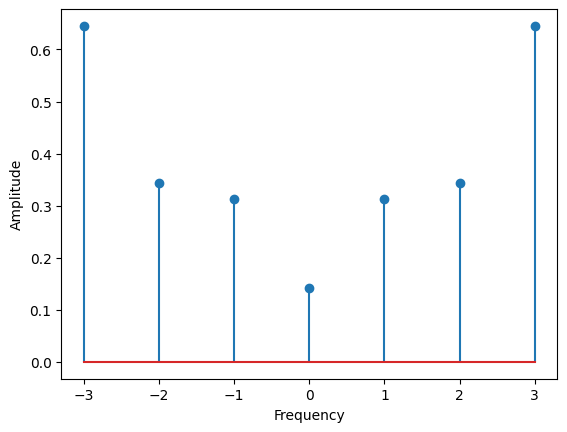

In [3]:
X = np.fft.fft(out)

X_freq = np.fft.fftfreq(X.size, 1/fs)

if X.size % 2 == 0:
    X = np.delete(X, len(X) // 2)
    X_freq = np.delete(X_freq, len(X_freq) // 2)
    
print(len(X))
X_shift = np.fft.fftshift(X)
X_freq_shift = np.fft.fftshift(X_freq)

fig, ax = plt.subplots()
ax.stem(X_freq_shift, np.abs(X_shift)/X_shift.size)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.savefig("figures/model_fct_spectr_light.png", dpi=100, transparent=True)
plt.show()

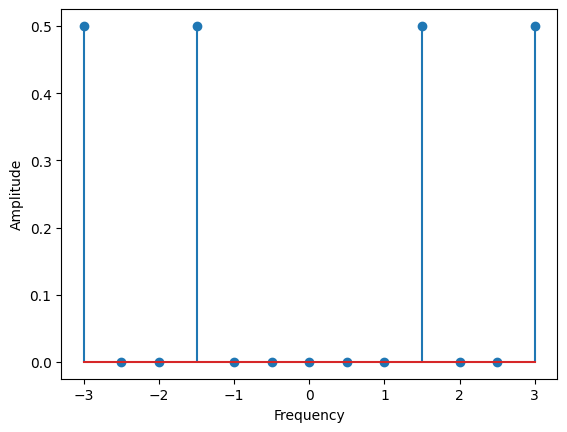

In [4]:
coeffs, freqs = Coefficients.get_spectrum(model_fct, mts=2, shift=True, trim=True)

fig, ax = plt.subplots()
ax.stem(freqs, np.abs(coeffs))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.savefig("figures/model_fct_spectr_ours_light.png", dpi=100, transparent=True)
plt.show()

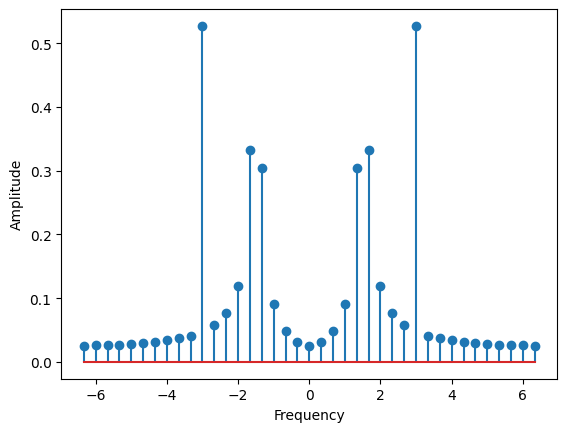

In [5]:
coeffs, freqs = Coefficients.get_spectrum(model_fct, mfs=2, mts=3, shift=True)

fig, ax = plt.subplots()
ax.stem(freqs, np.abs(coeffs))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.savefig("figures/model_fct_spectr_os_light.png", dpi=100, transparent=True)
plt.show()

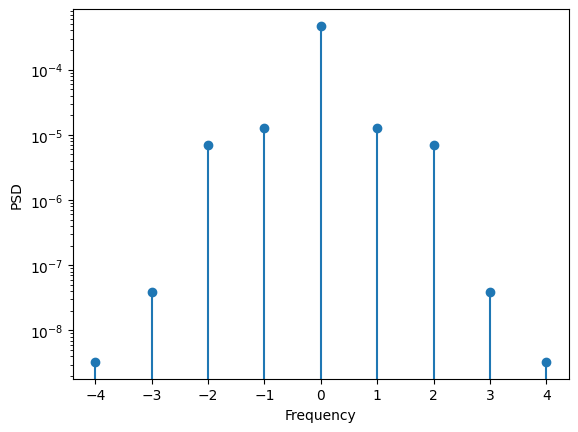

In [6]:
model = Model(
    n_qubits=4,
    n_layers=1,
    circuit_type="Circuit_19",
    random_seed=1000
)

coeffs, freqs = Coefficients.get_spectrum(model, mfs=1, mts=1
, shift=True)

psd = Coefficients.get_psd(coeffs)

fig, ax = plt.subplots()
ax.stem(freqs, psd)
ax.set_yscale('log')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.savefig("figures/model_psd_light.png", dpi=100, transparent=True)
plt.show()

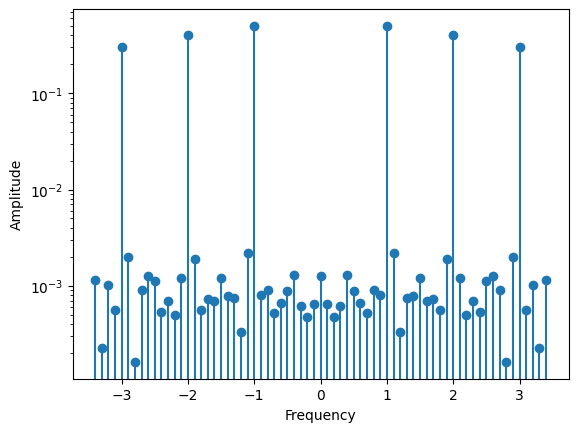

In [7]:
class Model_Fct:
    def __init__(self, c, f):
        self.c = c
        self.f = f
        self.degree = max(f)
        self.rng = np.random.default_rng(1000)
        self.n_input_feat = 1

    def __call__(self, inputs, **kwargs):
        inputs = inputs.flatten()
        noise = self.rng.normal(0, 0.01, inputs.size)
        # noise = 0
        return np.sum([c * np.cos(noise + ((inputs * f))) for f, c in zip(self.f, self.c)], axis=0)

freqs = [1,2,3]
coeffs = [1,0.8,0.6]

fs = max(freqs) * 2 + 1
model_fct = Model_Fct(coeffs,freqs)

out = model_fct(x)

coeffs, freqs = Coefficients.get_spectrum(model_fct, mfs=1, mts=10, trim=True, shift=True)

fig, ax = plt.subplots()
ax.stem(freqs, np.abs(coeffs))
ax.set_yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

In [8]:
from qml_essentials.coefficients import FourierTree

model = Model(
    n_qubits=4,
    n_layers=1,
    circuit_type="Circuit_19",
    output_qubit=0,
    random_seed=1000
)
fft_coeffs, fft_freqs = Coefficients.get_spectrum(model, shift=True)
fft_psd = Coefficients.get_psd(fft_coeffs)

In [9]:
fourier_tree = FourierTree(model)
an_coeffs, an_freqs = fourier_tree.get_spectrum(force_mean=True)
an_psd = Coefficients.get_psd(an_coeffs[0])

/home/lc3267/Documents/CodeWorkspace/qml-essentials/qml_essentials/model.py:595: RuntimeWarning: Explicit call to `_circuit` or `_variational` detected: `enc_params` is None, using `self.enc_params` instead.
  warnings.warn(


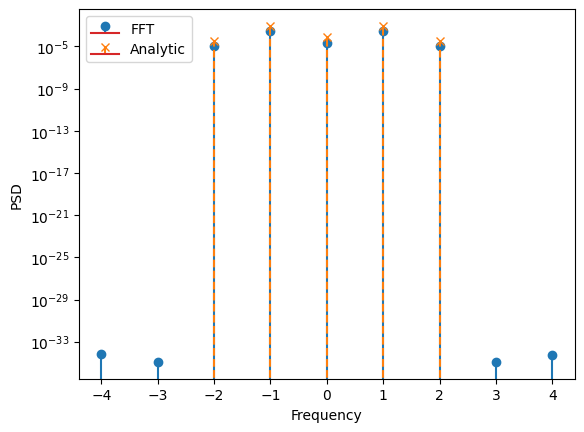

In [10]:

fig, ax = plt.subplots()
ax.stem(fft_freqs, fft_psd, label='FFT')
ax.stem(an_freqs[0], an_psd, linefmt='C1--', markerfmt='C1x', label='Analytic')
ax.set_yscale('log')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.legend(loc="upper left")
plt.savefig("figures/model_psd_an_light.png", dpi=100, transparent=True)
plt.show()

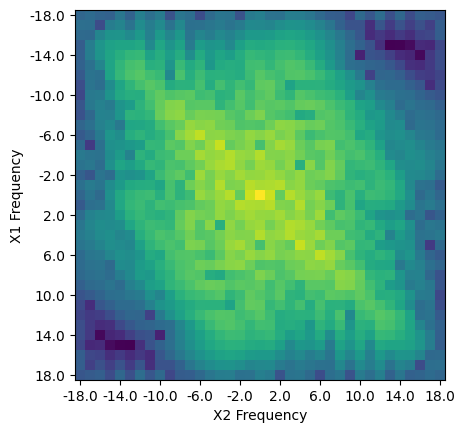

In [15]:
from matplotlib.colors import LogNorm
from qml_essentials.ansaetze import Gates
import pennylane as qml
import numpy as np

def none_encoding(*args, **kwargs):
    return None

fact = 0.00001
def exp_encoding1(w, wires, noise_params):
    w = w + (np.random.rand(w.size) * fact * np.pi)
    Gates.CRX(w, [wires,(wires+1)%2])
def exp_encoding2(w, wires, noise_params):
    w = w + (np.random.rand(w.size) * fact * np.pi)
    Gates.RX(w, wires)
def cust_encoding(w, wires, noise_params):
    Gates.Rot(w,w,w,wires)

model = Model(
    n_qubits=3,
    n_layers=3,
    circuit_type="Hardware_Efficient",
    random_seed=1000,
    encoding=[cust_encoding, cust_encoding],
)

coeffs, freqs = Coefficients.get_spectrum(model, mfs=2, mts=1, shift=True)

psd = Coefficients.get_psd(coeffs) + 1e-32
# psd = np.abs(coeffs.imag)

fig, ax = plt.subplots()
ax.imshow(psd, norm=LogNorm(vmin=psd.min(), vmax=psd.max()))
# ax.imshow(psd)
ax.set_xticks(np.arange(len(freqs))[::4])
ax.set_yticks(np.arange(len(freqs))[::4])
ax.set_xticklabels(freqs[::4])
ax.set_yticklabels(freqs[::4])
plt.xlabel('X2 Frequency')
plt.ylabel('X1 Frequency')
plt.savefig("figures/model_2d_psd_light.png", dpi=100, transparent=True)
plt.show()

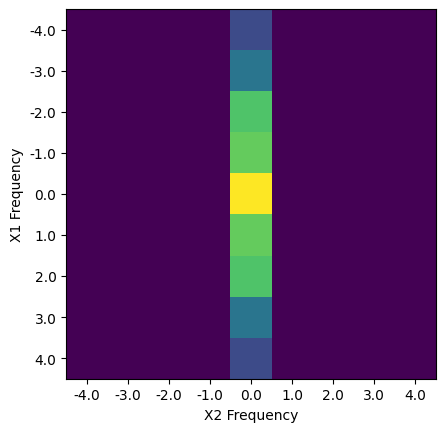

In [12]:
from matplotlib.colors import LogNorm
from qml_essentials.ansaetze import Gates
def none_encoding(*args, **kwargs):
    return None

model = Model(
    n_qubits=4,
    n_layers=1,
    circuit_type="Circuit_19",
    random_seed=1000,
    encoding=[Gates.RX, none_encoding]
)

coeffs, freqs = Coefficients.get_spectrum(model, mfs=1, mts=1
, shift=True)

psd = Coefficients.get_psd(coeffs) + 1e-10

fig, ax = plt.subplots()
ax.imshow(psd, norm=LogNorm(vmin=psd.min(), vmax=psd.max()))
ax.set_xticks(np.arange(len(freqs)))
ax.set_yticks(np.arange(len(freqs)))
ax.set_xticklabels(freqs)
ax.set_yticklabels(freqs)
plt.xlabel('X2 Frequency')
plt.ylabel('X1 Frequency')
plt.show()